## Exploratory Data Analysis

### Environment setting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2, mutual_info_regression, f_classif, mutual_info_classif
import sys

In [2]:
# to load custom libraries
LIBRARY_PATH = "."
sys.path.append(LIBRARY_PATH)

# load custom libraries
from utilsPlots import plot_density, plot_bars_target, na_plot, heatmap_triangle, heatmap_threshold, plot_stat_vs_mi_num, plot_stat_vs_mi_cat, plot_density_cat
from utilsStats import cramers_v, eta_squared

### Load data

In [3]:
# load data
df_train = pd.read_csv('data/train.csv')
# number samples and features
print(f'Number of samples {df_train.shape[0]}')
print(f'Number of features {df_train.shape[1]}')

Number of samples 8693
Number of features 14


In [4]:
# view data
df_train.head().T

,0,1,2,3,4
PassengerId,0001_01,0002_01,0003_01,0003_02,0004_01
HomePlanet,Europa,Earth,Europa,Europa,Earth
CryoSleep,False,False,False,False,False
Cabin,B/0/P,F/0/S,A/0/S,A/0/S,F/1/S
Destination,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e
Age,39.0,24.0,58.0,33.0,16.0
VIP,False,False,True,False,False
RoomService,0.0,109.0,43.0,0.0,303.0
FoodCourt,0.0,9.0,3576.0,1283.0,70.0
ShoppingMall,0.0,25.0,0.0,371.0,151.0


In [5]:
# distribution of target values
print(f'Number True values: {df_train["Transported"].sum()}')
print(f'Number False values: {(~df_train["Transported"]).sum()}')

Number True values: 4378
Number False values: 4315


### Duplicated samples

In [6]:
# duplicated samples
dupl = sum(df_train.duplicated(['PassengerId']))
print(f'Number of duplicated ID: {dupl}')

Number of duplicated ID: 0


Some names are duplicated, but the rest of the variables are different, so they are considered non-duplicate samples.

In [7]:
# duplicated Name
df = df_train[~df_train['Name'].isna()]
df[df.duplicated(['Name'], keep = False)].sort_values('Name').head(6)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
7270,7775_01,Europa,False,C/253/P,55 Cancri e,28.0,False,7.0,489.0,0.0,4.0,6027.0,Alraium Disivering,False
6296,6665_01,Europa,True,B/222/P,55 Cancri e,17.0,False,0.0,0.0,0.0,0.0,0.0,Alraium Disivering,True
476,0512_02,Europa,True,D/18/S,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,0.0,0.0,Ankalik Nateansive,True
2930,3176_01,Europa,False,E/196/P,TRAPPIST-1e,77.0,False,0.0,9032.0,0.0,128.0,1464.0,Ankalik Nateansive,True
8488,9071_01,Earth,False,F/1855/P,55 Cancri e,22.0,False,0.0,0.0,1072.0,46.0,3.0,Anton Woody,False
2991,3236_03,Earth,False,E/200/P,TRAPPIST-1e,18.0,False,0.0,30.0,0.0,756.0,5.0,Anton Woody,False


### NA values distribution

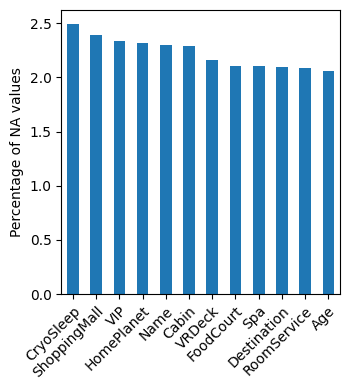

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


In [8]:
# NA values
na_plot(df_train)
# distribution of NA values in features
print(df_train.isnull().sum().sort_values(ascending=False))

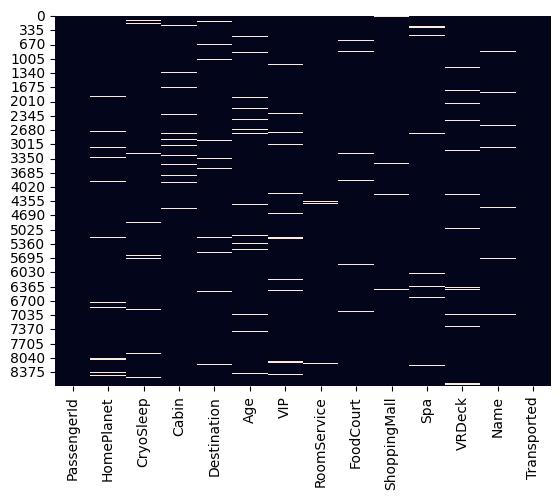

In [9]:
# NA by feature and sample
sns.heatmap(df_train.isna(), cbar=False)
plt.show()

In [10]:
# distribution of NA values in sample
df = df_train.drop(['PassengerId','Transported'], axis = 1)
na_perc = df.isna().sum(axis = 1)/len(df.columns)
print('\nDistribution of NA in samples')
print(na_perc.describe())
print(f'Percentage of samples without NA values: {sum(na_perc == 0)/df_train.shape[0]*100:.1f}%')


Distribution of NA in samples
count    8693.000000
mean        0.022278
std         0.042027
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.250000
dtype: float64
Percentage of samples without NA values: 76.0%


### Feature 'Deck'

Feature 'Deck' is splitted into three features 'Deck', 'Num' and 'Side'

In [11]:
# process Cabin feature (takes the form deck/num/side, where side can be either P for Port or S for Starboard)
df_train[['Deck','Num','Side']] = df_train['Cabin'].str.split('/', expand = True)

### Feature 'Name'

There is no useful information in the passengers' names.

In [12]:
df_train[['FirstName','Surname']] = df_train['Name'].str.split(' ', expand = True)
print(f'Number of different surnames: {df_train["Surname"].unique().shape[0]}')

Number of different surnames: 2218


### Feature exploration

#### Feature 'Num'

Num from 'Cabin' feature distribution
count    8494.000000
mean      600.367671
std       511.867226
min         0.000000
25%       167.250000
50%       427.000000
75%       999.000000
max      1894.000000
Name: Num, dtype: float64


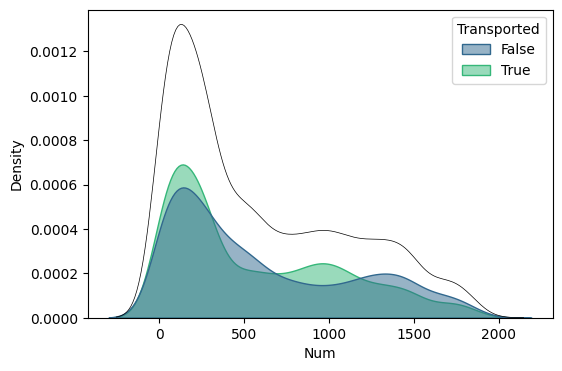

In [13]:
# distribution feature 'Num' 
print("Num from 'Cabin' feature distribution")
print(df_train[~df_train['Num'].isna()]['Num'].astype(int).describe())
# replace NA with 0
df_train['Num'] = df_train['Num'].fillna(0)
# convert to int keeping NAs
df_train['Num'] = df_train['Num'].astype(int)
plot_density_cat(df_train, ['Num'], 'Transported',  1, 1)

#### Feature 'Age'

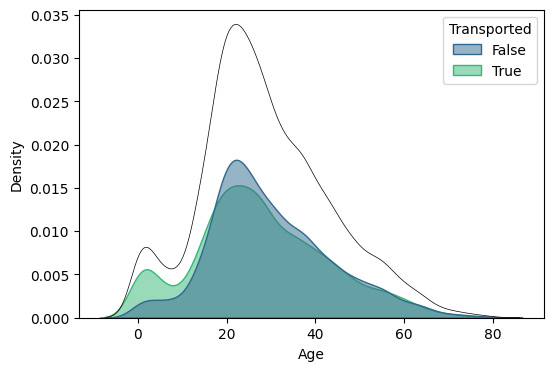

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64


In [14]:
# visualize 'Age' feature
plot_density_cat(df_train, ['Age'], 'Transported',  1, 1)
print(df_train['Age'].describe())

#### Features related to expenses

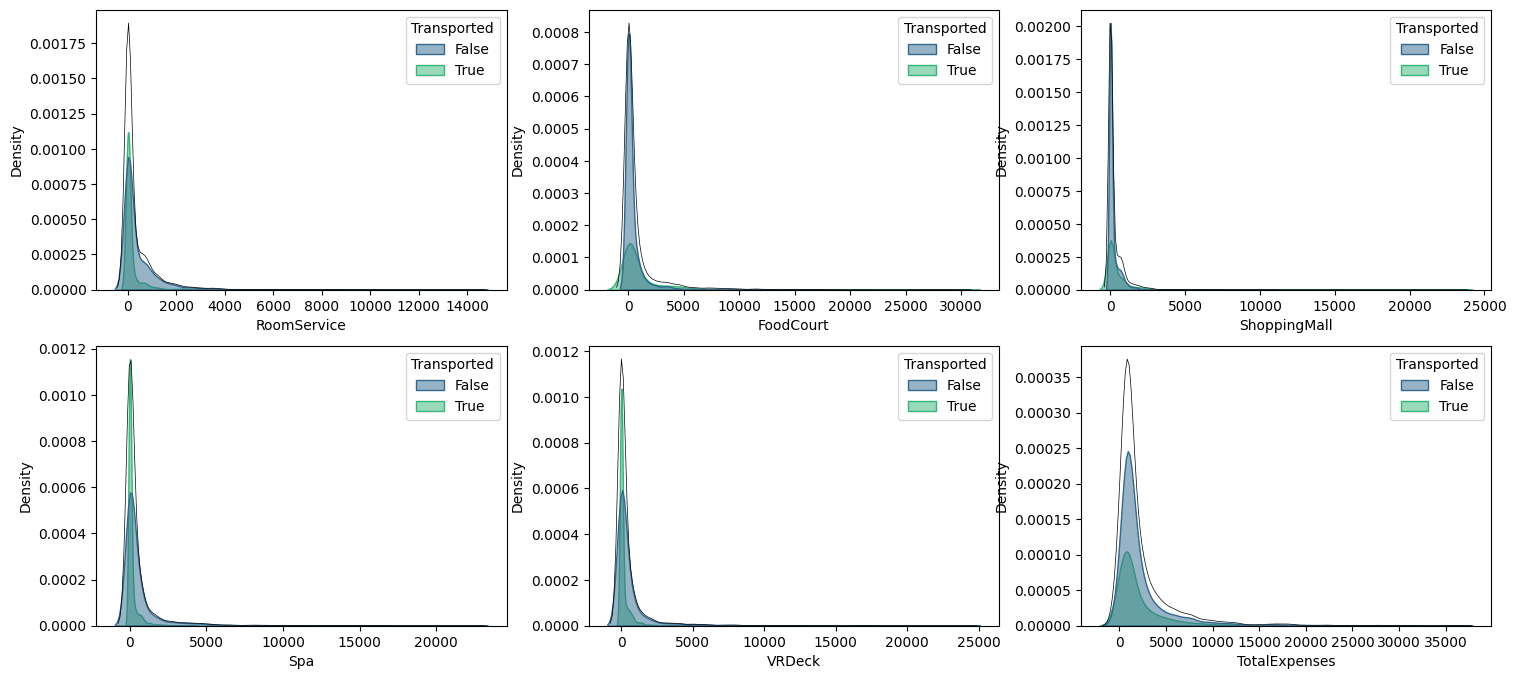

        RoomService     FoodCourt  ShoppingMall           Spa        VRDeck  \
count   5328.000000   5329.000000   5335.000000   5326.000000   5320.000000   
mean     350.146772    713.004316    270.586504    486.092940    475.716165   
std      803.080320   1970.547985    741.756155   1396.233751   1404.174304   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        3.000000      5.000000      2.000000      7.000000      4.000000   
75%      390.250000    537.000000    242.000000    354.750000    356.000000   
max    14327.000000  29813.000000  23492.000000  22408.000000  24133.000000   

       TotalExpenses  
count    5439.000000  
mean     2248.299687  
std      3245.061489  
min         0.000000  
25%       746.000000  
50%      1019.000000  
75%      2416.000000  
max     35987.000000  


In [15]:
# visualize 'RoomService', 'FoodCourt', 'ShoppingMail', 'Spa' and 'VRDeck' and new feature 'TotalExpenses'
expense_features = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalExpenses']
# calculate TotalExpenses features
df_train['TotalExpenses'] = df_train[expense_features[:-1]].sum(axis=1)
# remove samples with CryoSleep True (expenses equal to zero)
df = df_train[df_train['CryoSleep'] == False][expense_features + ['Transported']]
plot_density_cat(df, expense_features, 'Transported', 2, 3)
print(df.describe())

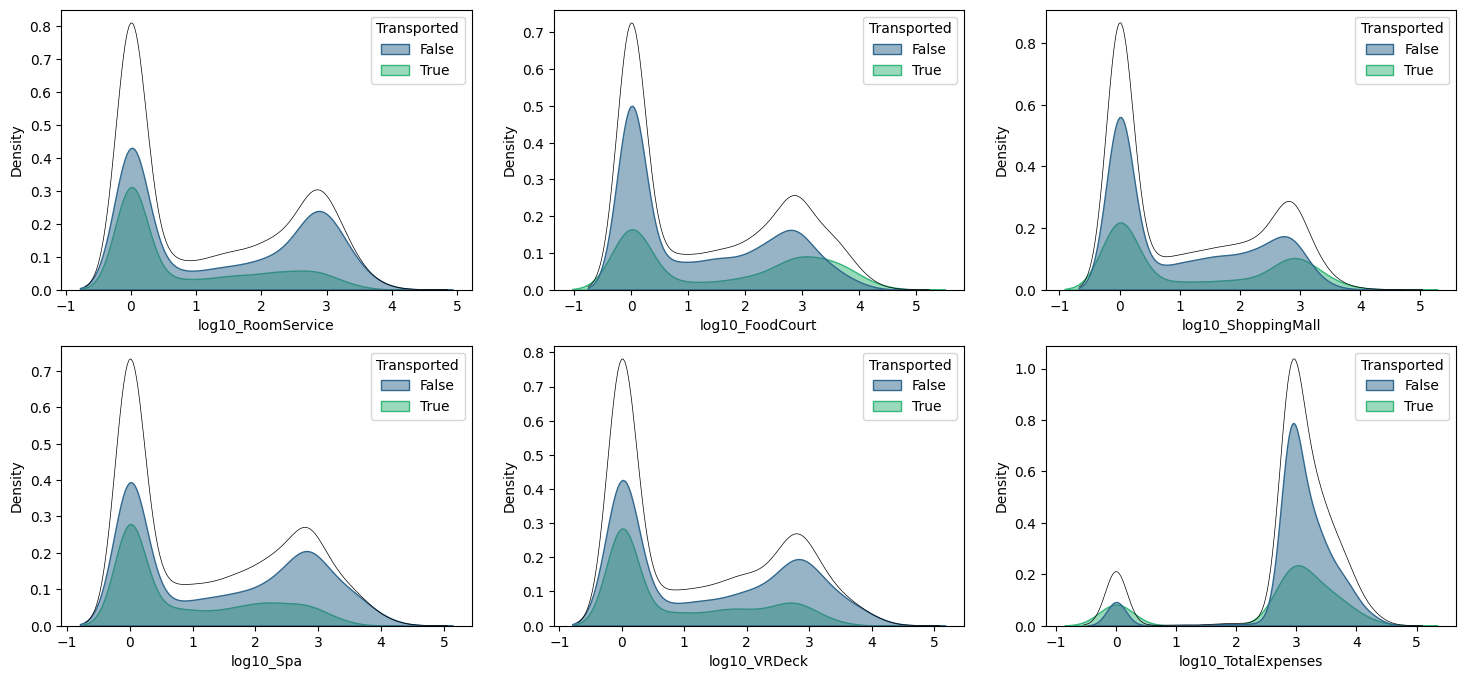

       log10_RoomService  log10_FoodCourt  log10_ShoppingMall    log10_Spa  \
count        5328.000000      5329.000000         5335.000000  5326.000000   
mean            1.199528         1.314941            1.106717     1.273267   
std             1.298383         1.391035            1.234381     1.305025   
min             0.000000         0.000000            0.000000     0.000000   
25%             0.000000         0.000000            0.000000     0.000000   
50%             0.602060         0.778151            0.477121     0.903090   
75%             2.592454         2.730782            2.385606     2.551145   
max             4.156186         4.474420            4.370938     4.350422   

       log10_VRDeck  log10_TotalExpenses  
count   5320.000000          5439.000000  
mean       1.219092             2.881298  
std        1.310807             1.010899  
min        0.000000             0.000000  
25%        0.000000             2.873321  
50%        0.698970             3.00860

In [16]:
# visualize 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa' and 'VRDeck' and new feature 'TotalExpenses' applying log10
expense_features_log10 = list(map(lambda x: 'log10_' + x, expense_features))
# apply log10
df_train[expense_features_log10] = df_train[expense_features].apply(lambda x: np.log10(x + 1))
# remove samples with CryoSleep True (expenses equal to zero)
df = df_train[df_train['CryoSleep'] == False][expense_features_log10 + ['Transported']]
plot_density_cat(df, expense_features_log10, 'Transported', 2, 3)
print(df.describe())

#### Categorical features

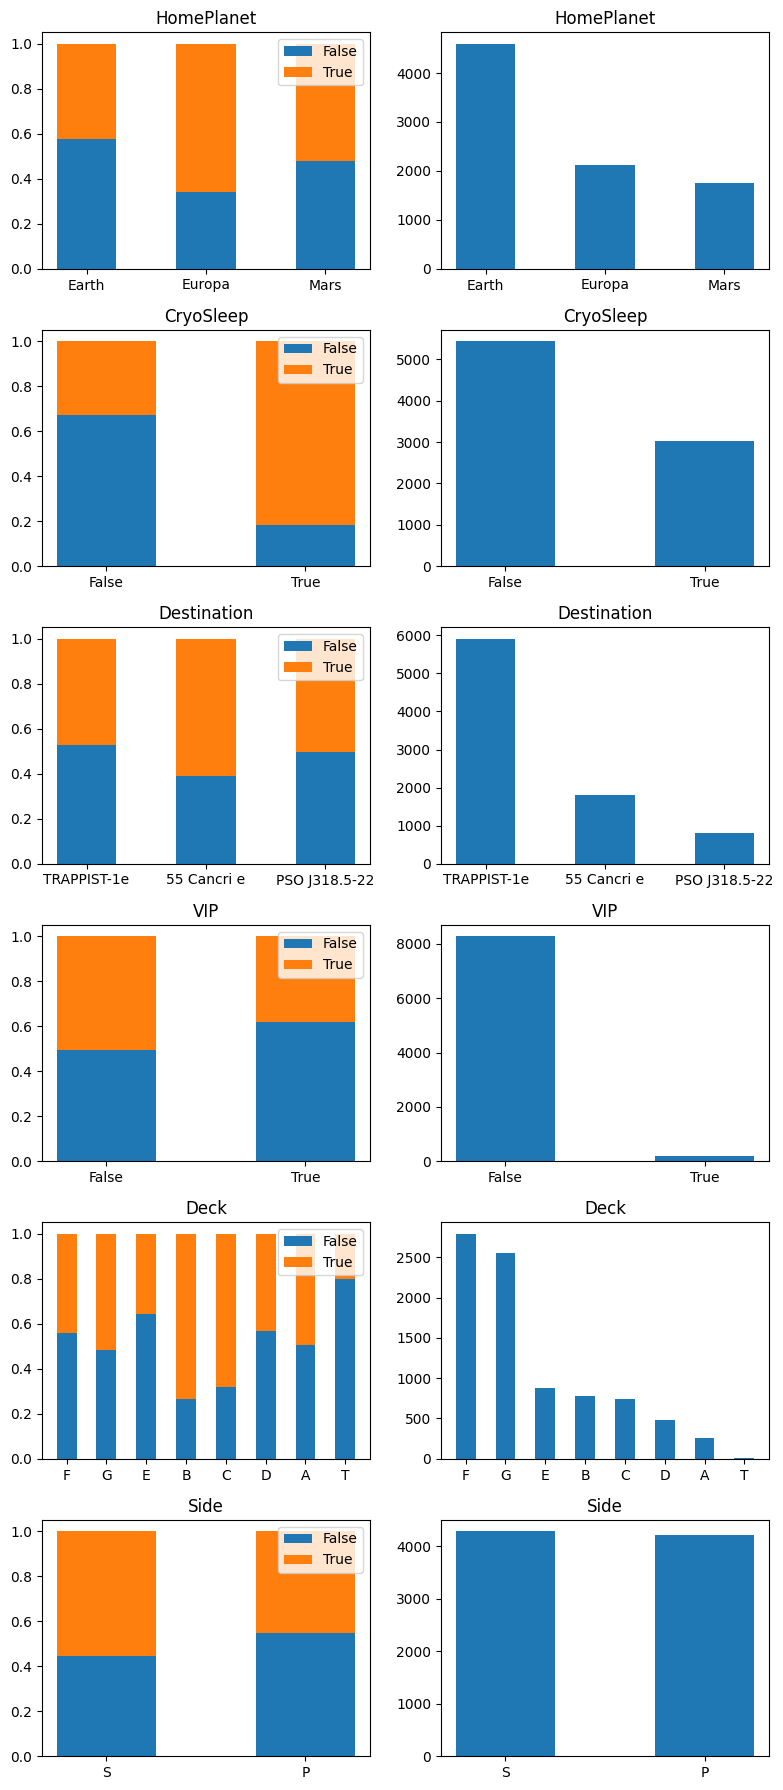

In [17]:
# visualize HomePlanet, CryoSleep, Destination, VIP
# TODO legend out of plot
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
plot_bars_target(df_train, cat_features , 'Transported', sort = True)

### New features

In [18]:
# New feature Age < 12 True/False
df_train['Age12'] = df_train['Age'].apply(lambda x: 'True' if x < 12 else 'False')
# New features Deck C,E,F/Others and Deck B,C,E,F/Others
df_train['Deck_OnlyB'] = df_train['Deck'].apply(lambda x: 'True' if x == 'B' else 'False')
df_train['Deck_CEF'] = df_train['Deck'].apply(lambda x: 'True' if x in ('C', 'E', 'F') else 'False')
df_train['Deck_BCEF'] = df_train['Deck'].apply(lambda x: 'True' if x in ('B', 'C', 'E', 'F') else 'False')
# New features log10_RoomService < 1 True/False
# Same for log10_FoodCourt, log10_ShoppingMall, log10_Spa, log10_VRDeck and log10_TotalExpenses
features = ['log10_RoomService', 'log10_FoodCourt', 'log10_ShoppingMall', 'log10_Spa', 'log10_VRDeck', 'log10_TotalExpenses']
for feature in features:
    new_feature = f'Expenses{feature}1'
    df_train[new_feature] = df_train[feature].apply(lambda x: 'True' if x < 1 else 'False')
new_features = ['Age12', 'Deck_OnlyB', 'Deck_CEF', 'Deck_BCEF'] + list(map(lambda x: f'Expenses{x}1', features))


### Correlation between explanatory features

#### Numerical features (Pearson correlation coeficient)

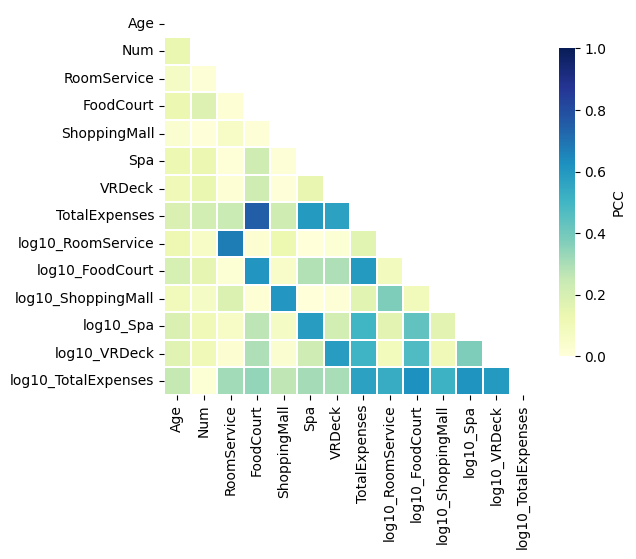

In [19]:
# correlation between quantitative features
selected_features = ['Age', 'Num'] + expense_features  + expense_features_log10
df = df_train[selected_features]
df = df.dropna()

# compute the correlation matrix
corr = np.abs(df.corr())

# plot heatmap
heatmap_triangle(corr, 'PCC')

#### Categorical features (Cramer's V test)

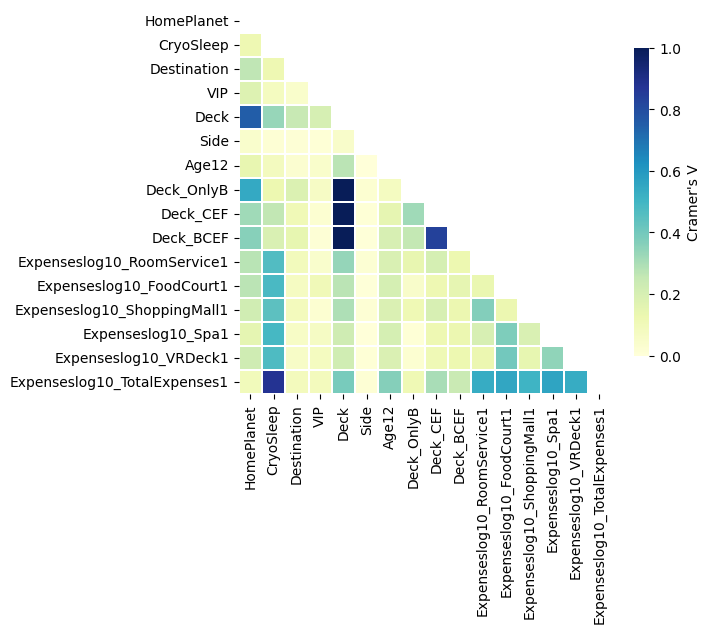

In [20]:
# relationship between categorical features (Cramer's V test)
categ_features= ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side'] + new_features

scores = []
for feature1 in categ_features:
    score_feature = []
    for feature2 in categ_features:
        score_feature.append(cramers_v(df_train[feature1], df_train[feature2]))
    scores.append(score_feature)

cramer = pd.DataFrame(scores, columns = categ_features, index = categ_features)

heatmap_triangle(cramer, "Cramer's V")

#### Categorical vs Numeric features (Eta squared)

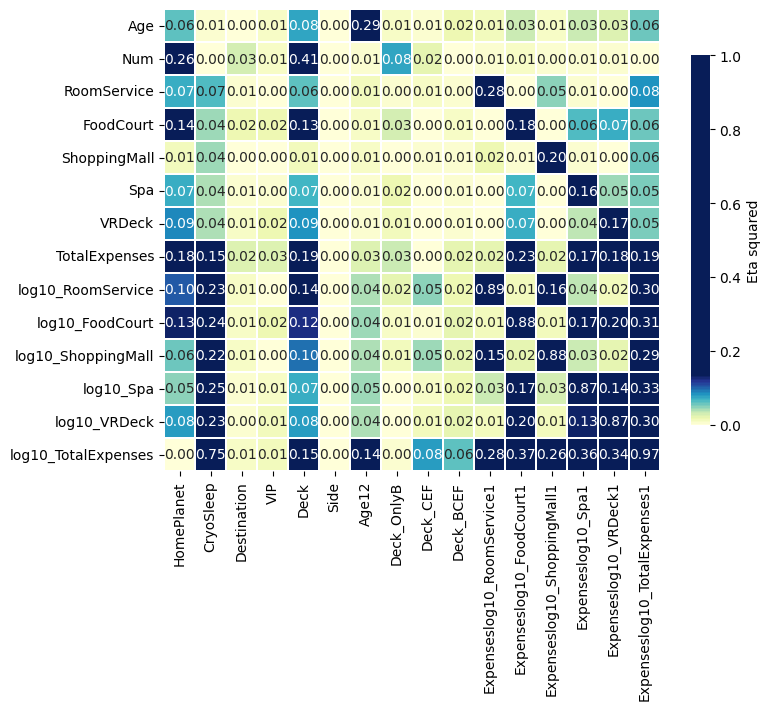

In [21]:
# relationship between quantitative vs qualitative features (Eta squared)
quant_features = ['Age', 'Num'] + expense_features + expense_features_log10

df = df_train[categ_features + quant_features]
df = df.dropna()

scores = []
for qf in quant_features:
    score_feature = []
    for cf in categ_features:
        formula = f'{qf} ~ {cf}'
        score_feature.append(eta_squared(df, formula))
    scores.append(score_feature)

eta2 = pd.DataFrame(scores, columns = categ_features, index = quant_features)

heatmap_threshold(eta2, 0.14, 'Eta squared')

### Correlation between target and explanatory features

#### Numerical features

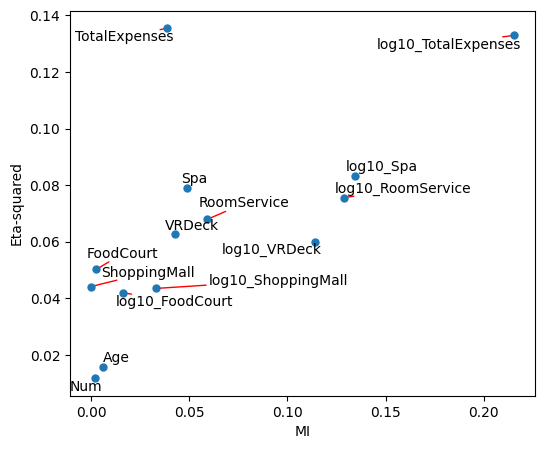

In [22]:
# relationship between quantitative features vs target (eta-squared/MI)

df = df_train[quant_features + ['Transported']]
df = df.dropna()

X = df[quant_features]
y = df['Transported']
mi = mutual_info_classif(X, y).tolist()
# f = f_classif(X, y)[0].tolist()
eta2 = []
for qf in quant_features:
    formula = f'{qf} ~ Transported'
    eta2.append(eta_squared(df, formula))

feature_stats = {'feature': quant_features, 'stat': eta2, 'mi': mi}

plot_stat_vs_mi_num(feature_stats, 'Eta-squared')

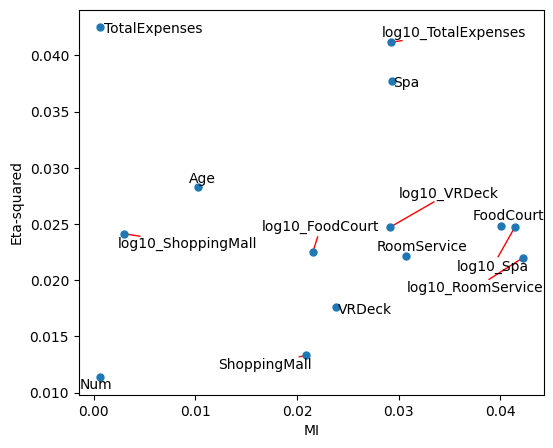

In [23]:
# relationship between quantitative features vs target (eta-squared/MI)
# remove CryoSleep True 

df = df_train[quant_features + ['Transported','CryoSleep']]
df = df.dropna()
df = df[df['CryoSleep'] != True]

#df['Num'] = df['Num'].astype(int)

X = df[quant_features]
y = df['Transported']
mi = mutual_info_classif(X, y).tolist()
# f = f_classif(X, y)[0].tolist()
eta2 = []
for qf in quant_features:
    formula = f'{qf} ~ Transported'
    eta2.append(eta_squared(df, formula))

feature_stats = {'feature': quant_features, 'stat': eta2, 'mi': mi}

plot_stat_vs_mi_num(feature_stats, 'Eta-squared')

#### Categorical features

16 [0.58105598 0.1227859 ]
17 [ 0.9943579  -0.63356997]
9 [-0.72676675  0.83127649]
19 [-0.41378709 -0.34610827]


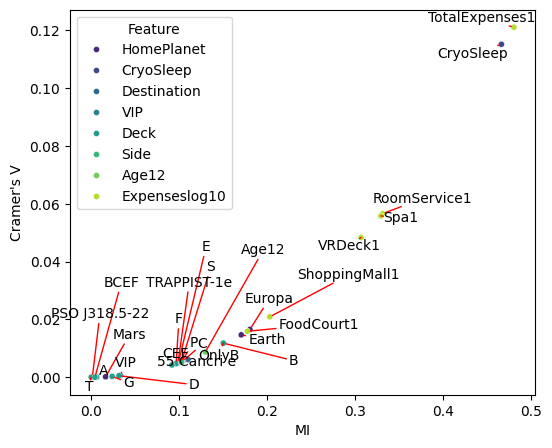

15 [0.93019099 0.80638747]
16 [-0.20126821  0.18698315]
8 [-0.95684974  0.3442775 ]
18 [0.4905491 0.2309276]


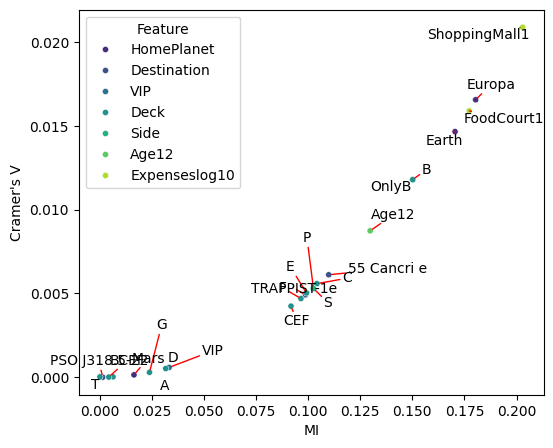

In [24]:
# relationship between categorical features vs target (Cramer's V test/MI)
# categ_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
TF_features = ['VIP', 'CryoSleep'] + new_features
drop_features = list(map(lambda x: f'{x}_False', TF_features))
df = df_train[categ_features + ['Transported']].dropna()
# one-hot encode (required for scikit-learn)
#X_encoded = pd.get_dummies(df[categ_features]).drop(['VIP_False', 'CryoSleep_False'], axis=1)
X_encoded = pd.get_dummies(df[categ_features])
X_encoded = pd.get_dummies(df[categ_features]).drop(drop_features, axis=1)
y = df['Transported']

# calculate MI scores for feature selection
mi = mutual_info_classif(X_encoded, y, discrete_features=True) 

# calculate Cramer's V scores for feature selection
cramer = []
for cf in X_encoded.columns:
    cramer.append(cramers_v(X_encoded[cf], df['Transported']))

# build dataframe for plot
features_levels = list(map(lambda x: x.split('_'),X_encoded.columns))
features = list(map(lambda x: x[0], features_levels))
levels = list(map(lambda x: x[1], features_levels))
feature_stats = {'feature': features, 'level': levels, 'stat': cramer, 'mi': mi}

df = pd.DataFrame(feature_stats)
df['level'] = df.apply(lambda row: row['feature'] if row['level'] == 'True' else row['level'], axis=1)

plot_stat_vs_mi_cat(df, "Cramer's V")

df_filt = df[~df['level'].isin(['CryoSleep','TotalExpenses1','RoomService1','Spa1','VRDeck1'])].reset_index(drop=True)
plot_stat_vs_mi_cat(df_filt, "Cramer's V")

### Relationship between expenses and 'CryoSleep' and 'Age' features

In [25]:
print("People with 'CryoSleep' equal to True have no expenses")
print(df_train[df_train['CryoSleep'] == True][['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum())
print("\nPeople with 'Age' less than 13 have no expenses")
print(df_train[df_train['Age'] < 13][['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum())

People with 'CryoSleep' equal to True have no expenses
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

People with 'Age' less than 13 have no expenses
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64


### Conclusions

Based on the results obtained for the correlations between the explanatory variables and the correlations between the explanatory variables and the target variable, the following variable usage is planned:

- log10TotalExpenses, CryoSleep, and log10TotalExpenses1 are variables with strong potential to explain the target variable. However, they should not be used together because they exhibit high multicollinearity.

- HomePlanet shows a strong association with the target variable. Additionally, it has no significant correlation with the aforementioned variables, making it a good candidate to combine with them.

- Age12, unlike Age, displays a high association with the target variable. It is strongly correlated with log10TotalExpenses and log10TotalExpenses1, so the best combination would be with CryoSleep.

- The variable Deck is highly associated with the target variable, particularly Deck B. Levels C, E, and F also show strong (though slightly weaker) associations. However, Deck is highly correlated with HomePlanet and log10TotalExpenses. Using only Deck B eliminates these correlations, allowing it to be combined with the other variables.

- The variables Destination and Side exhibit some association with the target variable and no significant correlations with the other explanatory variables.

Based on the observed data patterns, variables 'CryoSleep' and 'Age' can be confidently used to impute the expense-related variables. This imputation reduce the percentage of non-available values for the expense-related varaibles.